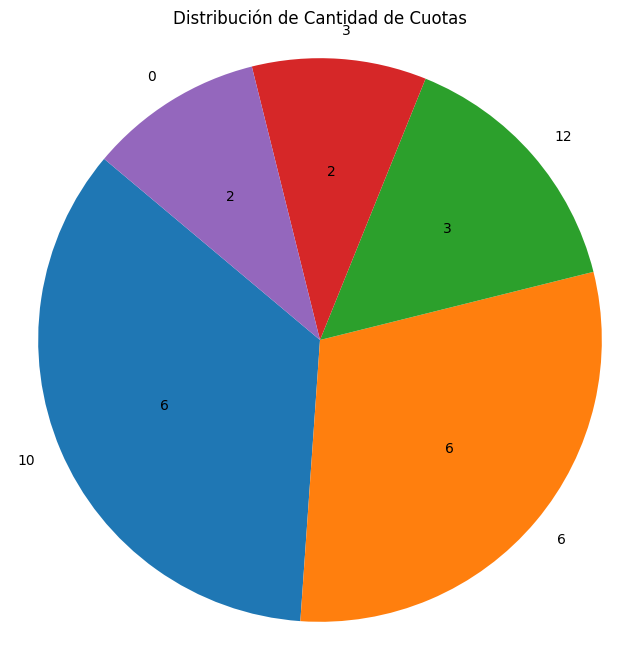

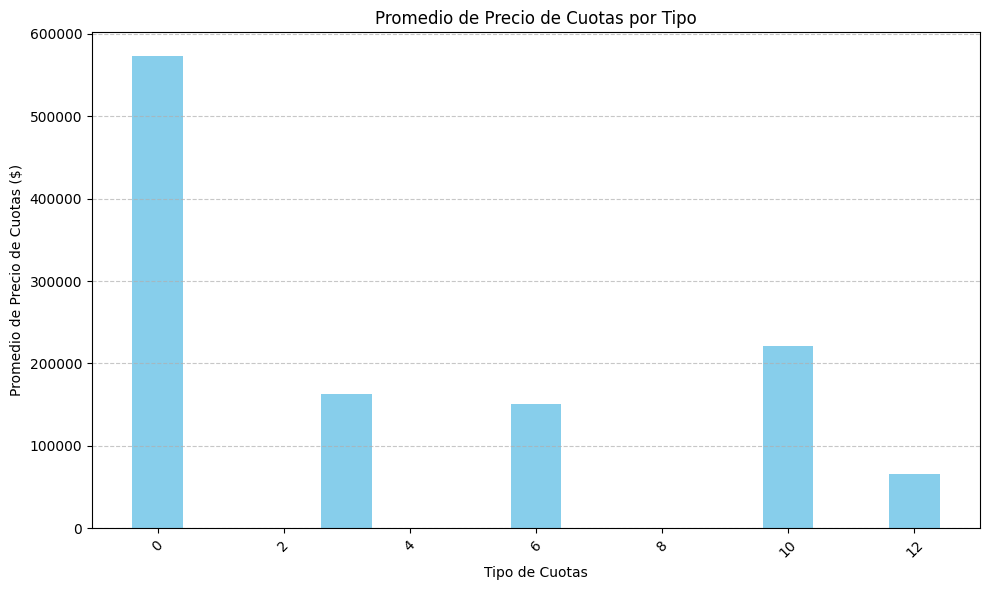

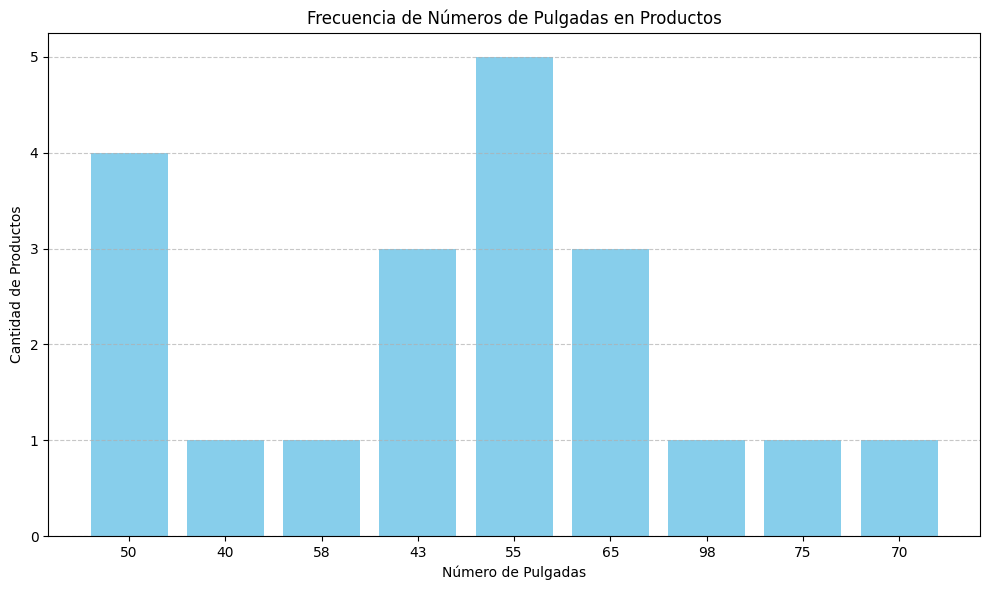

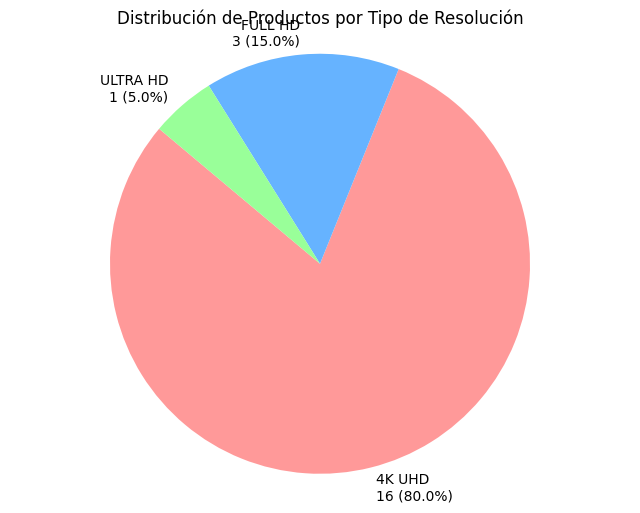

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def obtenerTexto(elementos, regex=None):
    listado = []
    for i in elementos:
        texto = i.getText().strip()
        if regex:
            match = re.search(regex, texto)
            if match:
                texto = match.group(1)
        listado.append(texto)
    return listado

diccionario = {}
pagina = requests.get("https://www.musimundo.com/super-ofertas/c/superofertas")

objeto_sopa = BeautifulSoup(pagina.content, 'html.parser')
nombres = objeto_sopa.find_all('h3', class_='mus-pro-name')
cuotas = objeto_sopa.find_all(class_='mus-pro-quotes')
precioOnline = objeto_sopa.find_all('span', class_='mus-pro-price-number')
precioAnterior = objeto_sopa.find_all('span', class_='line-trought strong')
precioCoutas = objeto_sopa.find_all('span', class_='mus-pro-quotes-price strong')

diccionario["nombres"] = obtenerTexto(nombres)
diccionario["cuotas"] = obtenerTexto(cuotas, regex=r'(\d+) x')
diccionario["precioOnline"] = obtenerTexto(precioOnline)
diccionario["precioAnterior"] = obtenerTexto(precioAnterior)
diccionario["precioCoutas"] = obtenerTexto(precioCoutas)

df = pd.DataFrame(diccionario)
df['cuotas'] = df['cuotas'].apply(lambda x: '0' if '$' in x else x)
df['precioAnterior'] = df['precioAnterior'].str.replace('$', '').str.strip()
df['precioOnline'] = df['precioOnline'].str.replace('$', '').str.strip()
df['precioCoutas'] = df['precioCoutas'].str.replace('$', '').str.replace('.', '').str.replace(',', '.').astype(float)


df.to_csv('ofertas_musimundo.csv', index=False)


df['cuotas'] = pd.to_numeric(df['cuotas'])

cuotas_counts = df['cuotas'].value_counts()


def func(pct, allvals):
    absolute = int(pct/100.*sum(allvals))
    return "{:d}".format(absolute)


plt.figure(figsize=(8, 8))
plt.pie(cuotas_counts, labels=cuotas_counts.index, autopct=lambda pct: func(pct, cuotas_counts), startangle=140)
plt.title('Distribución de Cantidad de Cuotas')
plt.axis('equal')
plt.show()



df_promedio = df.groupby('cuotas')['precioCoutas'].mean().reset_index()

df_promedio = df_promedio.sort_values(by='cuotas')

plt.figure(figsize=(10, 6))
plt.bar(df_promedio['cuotas'], df_promedio['precioCoutas'], color='skyblue')
plt.xlabel('Tipo de Cuotas')
plt.ylabel('Promedio de Precio de Cuotas ($)')
plt.title('Promedio de Precio de Cuotas por Tipo')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

def extraer_numero_pulgadas(nombre):
    match = re.search(r'(\d+)\s*PULGADAS', nombre)
    if match:
        return match.group(1)
    else:
        return None

numeros_pulgadas = df['nombres'].apply(lambda x: extraer_numero_pulgadas(x)).dropna().tolist()


frecuencia_pulgadas = Counter(numeros_pulgadas)

pulgadas = list(frecuencia_pulgadas.keys())
frecuencias = list(frecuencia_pulgadas.values())

plt.figure(figsize=(10, 6))
plt.bar(pulgadas, frecuencias, color='skyblue')
plt.xlabel('Número de Pulgadas')
plt.ylabel('Cantidad de Productos')
plt.title('Frecuencia de Números de Pulgadas en Productos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(pulgadas)
plt.tight_layout()
plt.show()


def extraer_resolucion(nombre):
    if '4K UHD' in nombre:
        return '4K UHD'
    elif 'FULL HD' in nombre:
        return 'FULL HD'
    elif 'ULTRA HD' in nombre:
        return 'ULTRA HD'
    else:
        return None

# Crear un DataFrame de ejemplo
df = pd.DataFrame({'nombres': df['nombres']})

# Aplicar la función de extracción para obtener la resolución de cada producto
df['resolucion'] = df['nombres'].apply(extraer_resolucion)

# Contar las ocurrencias de cada tipo de resolución
contador_resolucion = Counter(df['resolucion'].dropna())

# Preparar datos para el gráfico de torta
labels = list(contador_resolucion.keys())
sizes = list(contador_resolucion.values())
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=[f'{label}\n{size} ({size/sum(sizes)*100:.1f}%)' for label, size in zip(labels, sizes)],
        colors=colors, autopct='', startangle=140)
plt.title('Distribución de Productos por Tipo de Resolución')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()